# Chapter 6 - Exercises

> Author : Badr TAJINI - Large Language model (LLMs) - ESIEE 2024-2025

---


# **Run these cells after resetting the runtime, for each exercise**

In [1]:
from importlib.metadata import version
!pip install tiktoken
pkgs = ["matplotlib",
        "numpy",
        "tiktoken",
        "torch",
        "tensorflow", # For OpenAI's pretrained weights
        "pandas"      # Dataset loading
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 2.1 MB/s eta 0:00:00
matplotlib version: 3.10.0
numpy version: 1.26.4
tiktoken version: 0.8.0
torch version: 2.5.1+cu121
tensorflow version: 2.17.1
pandas version: 2.2.2


In [2]:
from google.colab import drive
drive.mount('/content/drive')
import sys
import os

module_path = '/content/drive/MyDrive/DSIA_LLM/lab6/main_code' # Assuming 'previous_labs.py' is in this directory
if module_path not in sys.path:
  sys.path.append(module_path)

Mounted at /content/drive


In [3]:
import urllib.request
import zipfile
import os
from pathlib import Path
import pandas as pd
import torch
import tiktoken
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from gpt_class_finetune import download_and_unzip_spam_data,create_balanced_dataset,random_split, SpamDataset, plot_values
import time
from gpt_download import download_and_load_gpt2
from previous_labs import GPTModel, load_weights_into_gpt

In [4]:
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"


download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])

balanced_df = create_balanced_dataset(df)

balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)

train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

tokenizer = tiktoken.get_encoding("gpt2")

train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=80,
    tokenizer=tokenizer
)
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=80,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=80,
    tokenizer=tokenizer
)

File downloaded and saved as sms_spam_collection/SMSSpamCollection.tsv


In [5]:
num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [6]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)

## Exercise 6.1: Increasing the context length

**Padding Input Sequences in Neural Language Models**

**Key Research Question: How does padding inputs to the maximum `token` length affect model predictive performance?**

*Methodological Approach:*
- Implement systematic `token` padding
- Analyze padding's impact on model performance
- Explore input representation interactions

*Critical Parameters:*
- Input `padding` strategy
- Maximum `token` length
- Predictive performance metrics

*Recommended Investigation:*
1. Implement maximum-length input `padding`
2. Measure performance variations
3. Compare padded versus non-padded inputs
4. Assess computational implications

In the lab, we used the "max_length=None" parameters when padding the datasets. It resulted in a length of 120. To compare it with a systematic length padding, We will use "max_length=80" for the three dataset. (Since I used the same dataset for the 3 exercises, the code is on top of the notebook)

In [7]:
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)

for param in model.parameters():
    param.requires_grad = False

torch.manual_seed(123)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)
model.to(device)

for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 94.6kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 2.14MiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 76.9kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [00:19<00:00, 25.7MiB/s]
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 4.52MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 1.39MiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 1.35MiB/s]


In [8]:
from gpt_class_finetune import train_classifier_simple, calc_accuracy_loader
########################################
# Finetune modified model
########################################

start_time = time.time()
torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.116, Val loss 2.359
Ep 1 (Step 000050): Train loss 0.596, Val loss 0.581
Ep 1 (Step 000100): Train loss 0.485, Val loss 0.512
Training accuracy: 85.00% | Validation accuracy: 80.00%
Ep 2 (Step 000150): Train loss 0.495, Val loss 0.386
Ep 2 (Step 000200): Train loss 0.194, Val loss 0.215
Ep 2 (Step 000250): Train loss 0.144, Val loss 0.126
Training accuracy: 92.50% | Validation accuracy: 95.00%
Ep 3 (Step 000300): Train loss 0.161, Val loss 0.122
Ep 3 (Step 000350): Train loss 0.124, Val loss 0.055
Training accuracy: 97.50% | Validation accuracy: 97.50%
Ep 4 (Step 000400): Train loss 0.029, Val loss 0.059
Ep 4 (Step 000450): Train loss 0.228, Val loss 0.080
Ep 4 (Step 000500): Train loss 0.135, Val loss 0.062
Training accuracy: 97.50% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.187, Val loss 0.057
Ep 5 (Step 000600): Train loss 0.057, Val loss 0.039
Training accuracy: 100.00% | Validation accuracy: 100.00%
Training completed in 0.68 mi

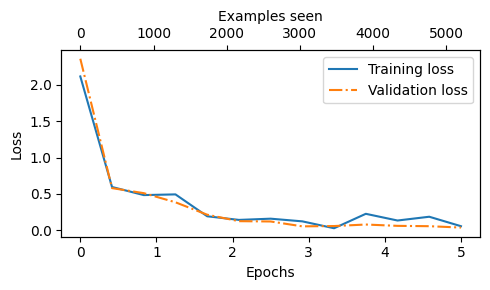

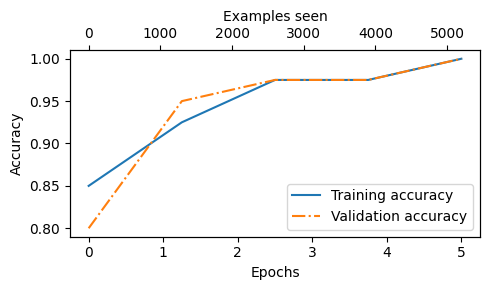

In [9]:
########################################
# Plot results
########################################

# loss plot
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

# accuracy plot
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))
plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [10]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 97.31%
Validation accuracy: 98.66%
Test accuracy: 96.00%


In [11]:
torch.save(model.state_dict(), "review_classifier_Padding_80.pth")

With the "max_length=None" dataset (in the lab), we obtained an accuracy of :

Training accuracy: 97.21%
Validation accuracy: 97.32%
Test accuracy: 95.67%

With the "max_length=80" dataset, we obtained an accuracy of:

Training accuracy: 97.31%
Validation accuracy: 98.66%
Test accuracy: 96.00%

We see some improvement just on the accuracy.

We also have a similar accuracy for training and validation on the plotted accuracy.

For the training time, we had 0.98minutes for the first case and 0.68minutes for the second case, so we see that reducing the size of the padding also reduce the size of the dataset and as such shorten the training time.

To conclude, in our case having a shorter max_length ended up increasing the accuracy while reducing the computation time. However, in my opinion, if the dataset was containing longer sentences shortening the padding would lower the accuracy but shorten the training time. At the opposite, keeping the longest sentence as reference would increase the accuracy but make the training time longer.

## Exercise 6.2: Finetuning the whole model

**Model-Wide Fine-Tuning Performance Assessment**

**Key Research Question: What is the impact of `fine-tuning` the entire transformer model versus a single final block on predictive performance?**


*Methodological Approach:*
- Implement comprehensive model `fine-tuning`
- Compare performance against single block tuning
- Assess computational and representational changes

*Critical Parameters:*
- Full model `fine-tuning` strategy
- Performance evaluation metrics
- Comparative analysis methodology

*Recommended Investigation:*
1. `Fine-tune` entire transformer model
2. Measure predictive performance metrics
3. Compare with previous single-block tuning results
4. Analyze performance variation mechanisms

For this exercise, we will keep the dataset with padding set to 80 token since it fasten the training time while keeping a good accuracy. The new model will be compared with the one trained on the exercise 6.1.

# **I reset the runtime between each exercise to clean the RAM (Run the cells at the TOP again)**

In [7]:
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)

torch.manual_seed(123)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)
model.to(device)

for param in model.parameters():
    param.requires_grad = True

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 204kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 3.40MiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 133kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [00:15<00:00, 31.6MiB/s]
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 4.99MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 1.47MiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 1.42MiB/s]


In [8]:
from gpt_class_finetune import train_classifier_simple, calc_accuracy_loader
########################################
# Finetune modified model
########################################

start_time = time.time()
torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.087, Val loss 1.853
Ep 1 (Step 000050): Train loss 0.238, Val loss 0.237
Ep 1 (Step 000100): Train loss 0.118, Val loss 0.164
Training accuracy: 95.00% | Validation accuracy: 97.50%
Ep 2 (Step 000150): Train loss 0.166, Val loss 0.089
Ep 2 (Step 000200): Train loss 0.010, Val loss 0.148
Ep 2 (Step 000250): Train loss 0.103, Val loss 0.159
Training accuracy: 95.00% | Validation accuracy: 97.50%
Ep 3 (Step 000300): Train loss 0.043, Val loss 0.072
Ep 3 (Step 000350): Train loss 0.011, Val loss 0.090
Training accuracy: 100.00% | Validation accuracy: 100.00%
Ep 4 (Step 000400): Train loss 0.018, Val loss 0.028
Ep 4 (Step 000450): Train loss 0.020, Val loss 0.032
Ep 4 (Step 000500): Train loss 0.059, Val loss 0.035
Training accuracy: 100.00% | Validation accuracy: 100.00%
Ep 5 (Step 000550): Train loss 0.001, Val loss 0.009
Ep 5 (Step 000600): Train loss 0.001, Val loss 0.013
Training accuracy: 100.00% | Validation accuracy: 100.00%
Training completed in 1.9

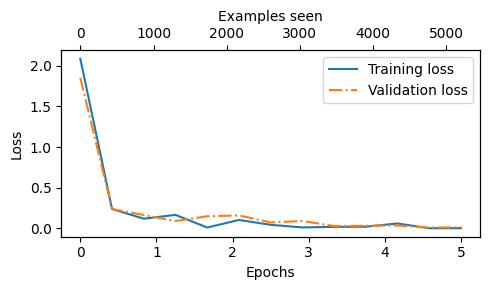

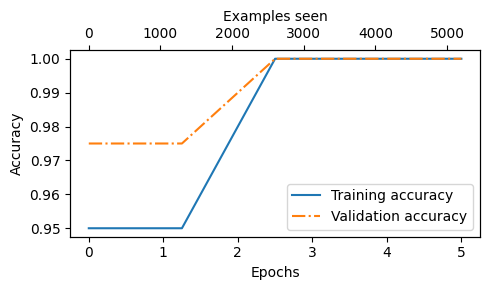

In [9]:
########################################
# Plot results
########################################

# loss plot
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

# accuracy plot
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))
plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [10]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 100.00%
Validation accuracy: 99.33%
Test accuracy: 98.00%


In [11]:
torch.save(model.state_dict(), "review_classifier_Padding_80_All_Layers.pth")

When comparing both models, we directly see that the model with all layers fine tuned achieve a really high accuracy on each loader. We still have a small difference between training and test accuracy, but not that big so we can say we only have a small overfitting like before. The convergence was really fast for both training and validation.

At the opposite, when we look at the computation details, we see that training all layers take around 3 times longer and use a lot more RAM.

To conclude we can see that training all layers allow us to have a model who perform better for the task, but it require more time and RAM to do it.

In my opinion there is also the risk of overfitting depending of the size of the dataset, since all weights are retrained on the dataset.

## Exercise 6.3: Finetuning the first versus last token

**First Token Fine-Tuning: Predictive Performance Analysis**

**Key Research Question: How do predictive performance characteristics change when fine-tuning the first output `token` compared to the last output `token`?**

*Methodological Approach:*
- Fine-tune first output `token`
- Compare performance against last `token` fine-tuning
- Assess representational learning variations

*Critical Parameters:*
- Initial `token` fine-tuning strategy
- Performance evaluation metrics
- Comparative analysis methodology

*Recommended Investigation:*
1. Implement first `token` fine-tuning
2. Measure predictive performance
3. Compare with last `token` fine-tuning results
4. Analyze performance variation mechanisms

# **I reset the runtime between each exercise to clean the RAM (Run the cells at the TOP again)**

For this exercise, we will keep the dataset with padding set to 80 token since it fasten the training time while keeping a good accuracy. The new model will be compared with the one trained on the exercise 6.1 to have a shorten training time, lower RAM consumption, and not have a perfect accuracy to have a better comparaison.

In [11]:
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)

for param in model.parameters():
    param.requires_grad = False

torch.manual_seed(123)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)
model.to(device)

for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [10]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, 0, :]  # Logits of first output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, 0, :]  # Logits of last output token
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            examples_seen += input_batch.shape[0] # New: track examples instead of tokens
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [12]:
########################################
# Finetune modified model
########################################

start_time = time.time()
torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 1.234, Val loss 1.352
Ep 1 (Step 000050): Train loss 0.710, Val loss 0.711
Ep 1 (Step 000100): Train loss 0.630, Val loss 0.708
Training accuracy: 60.00% | Validation accuracy: 50.00%
Ep 2 (Step 000150): Train loss 0.654, Val loss 0.693
Ep 2 (Step 000200): Train loss 0.631, Val loss 0.682
Ep 2 (Step 000250): Train loss 0.556, Val loss 0.685
Training accuracy: 70.00% | Validation accuracy: 60.00%
Ep 3 (Step 000300): Train loss 0.574, Val loss 0.668
Ep 3 (Step 000350): Train loss 0.508, Val loss 0.664
Training accuracy: 72.50% | Validation accuracy: 57.50%
Ep 4 (Step 000400): Train loss 0.487, Val loss 0.648
Ep 4 (Step 000450): Train loss 0.492, Val loss 0.671
Ep 4 (Step 000500): Train loss 0.470, Val loss 0.642
Training accuracy: 75.00% | Validation accuracy: 60.00%
Ep 5 (Step 000550): Train loss 0.520, Val loss 0.641
Ep 5 (Step 000600): Train loss 0.408, Val loss 0.617
Training accuracy: 80.00% | Validation accuracy: 65.00%
Training completed in 0.68 minu

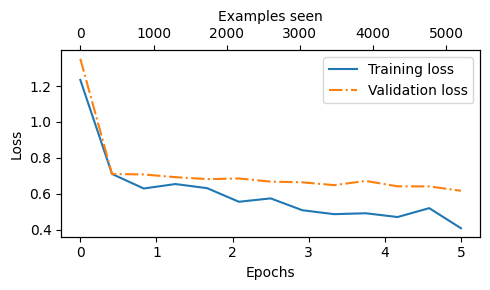

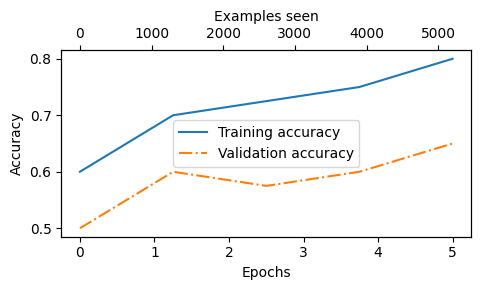

In [13]:
########################################
# Plot results
########################################

# loss plot
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

# accuracy plot
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))
plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [14]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 78.17%
Validation accuracy: 77.85%
Test accuracy: 75.67%


In [15]:
torch.save(model.state_dict(), "review_classifier_Padding_80_First_Token.pth")

When comparing this model with the model of the exercise 6.1 we can directly see that this model have really poor accuracy. We have 96% Test accuracy on the first model and 75.67% on this one. Moreover if we look at the plot we can see that we have overfitting appearing.

For the computation detail, we achieve similar result on both model.

We can conclude that fine tunning the model on the first token is inneficient. This is logical since it means that the model will train by looking at only one token and not the full sentence.